
# Optode EDA & 3D Visualization

This notebook reproduces the 1" time-series plot and the 3D time–depth scatter plot we created.
- Update `BASE_ZIP_PATH` or `BASE_DIR` to point to your data.
- The code expects file names like `SMORES optode_6 3 inch.csv` and columns including `Epoch`, `DO`, `T`.


In [1]:

import os, re, math, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True


In [10]:

# === Configure data location ===
# If your files are in a zip, set BASE_ZIP_PATH and run the extraction cell.
BASE_ZIP_PATH = '/Users/ramanzatsarenko/smores_proj/CSVperOptode_2'   # change if needed
EXTRACT_DIR = '/Users/ramanzatsarenko/smores_proj/CSVperOptode'          # change if needed

# If you already have a folder with CSVs, set BASE_DIR and skip extraction.
BASE_DIR = EXTRACT_DIR


In [11]:

# Optional: extract from zip if the folder doesn't already exist
# import os
# if BASE_ZIP_PATH and not os.path.exists(EXTRACT_DIR):
    # with zipfile.ZipFile(BASE_ZIP_PATH, 'r') as zf:
        # zf.extractall(EXTRACT_DIR)
print('Data directory:', BASE_DIR)
for root, _, files in os.walk(BASE_DIR):
    print(f'  {len(files)} files in {root}')

Data directory: /Users/ramanzatsarenko/smores_proj/CSVperOptode
  26 files in /Users/ramanzatsarenko/smores_proj/CSVperOptode


In [12]:

def parse_info(fname):
    """Return (optode_id, depth_inch) from filename like 'SMORES optode_6 3 inch.csv'"""
    m = re.search(r'optode_(\d+)\s+(\d+)\s+inch', os.path.basename(fname))
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

# Collect csv files
csv_files = []
for root, _, files in os.walk(BASE_DIR):
    for f in files:
        if f.endswith('.csv') and 'optode_' in f:
            csv_files.append(os.path.join(root, f))

len(csv_files), csv_files[:5]


(26,
 ['/Users/ramanzatsarenko/smores_proj/CSVperOptode/SMORES optode_6 3 inch.csv',
  '/Users/ramanzatsarenko/smores_proj/CSVperOptode/SMORES optode_12 3 inch.csv',
  '/Users/ramanzatsarenko/smores_proj/CSVperOptode/SMORES optode_3 3 inch.csv',
  '/Users/ramanzatsarenko/smores_proj/CSVperOptode/SMORES optode_2 1 inch.csv',
  '/Users/ramanzatsarenko/smores_proj/CSVperOptode/SMORES optode_19 6 inch.csv'])

In [13]:

# Read all CSVs robustly and standardize columns
records = []
for path in csv_files:
    oid, depth = parse_info(path)
    if oid is None:
        continue
    try:
        df = pd.read_csv(path)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding='latin1')
    # Ensure required columns exist
    colmap = {c.strip(): c for c in df.columns}
    if 'Epoch' not in colmap or 'DO' not in colmap:
        continue
    df = df[[colmap['Epoch'], colmap['DO']]].rename(columns={colmap['Epoch']: 'Epoch', colmap['DO']: 'DO'})
    df['file'] = os.path.basename(path)
    df['optode_id'] = oid
    df['depth_inch'] = depth
    records.append(df)

all_df = pd.concat(records, ignore_index=True)
all_df['datetime'] = pd.to_datetime(all_df['Epoch'], unit='s', utc=True)
all_df['datetime'] = all_df['datetime'].dt.tz_convert('US/Eastern')
print('Rows:', len(all_df), ' | Optodes:', all_df.optode_id.nunique(), ' | Depths:', sorted(all_df.depth_inch.unique()))
all_df.head()


Rows: 17187  | Optodes: 26  | Depths: [1, 3, 6]


,Epoch,DO,file,optode_id,depth_inch,datetime
0,1.744035e+09,8.258077,SMORES optode_6 3 inch.csv,6,3,2025-04-07 10:13:04.662020922-04:00
1,1.744035e+09,8.427457,SMORES optode_6 3 inch.csv,6,3,2025-04-07 10:13:59.230993986-04:00
2,1.744035e+09,8.433817,SMORES optode_6 3 inch.csv,6,3,2025-04-07 10:14:51.552015066-04:00
3,1.744035e+09,8.396122,SMORES optode_6 3 inch.csv,6,3,2025-04-07 10:15:43.760993004-04:00
4,1.744035e+09,8.005728,SMORES optode_6 3 inch.csv,6,3,2025-04-07 10:16:36.039986372-04:00


## 1-inch Depth — DO Time Series

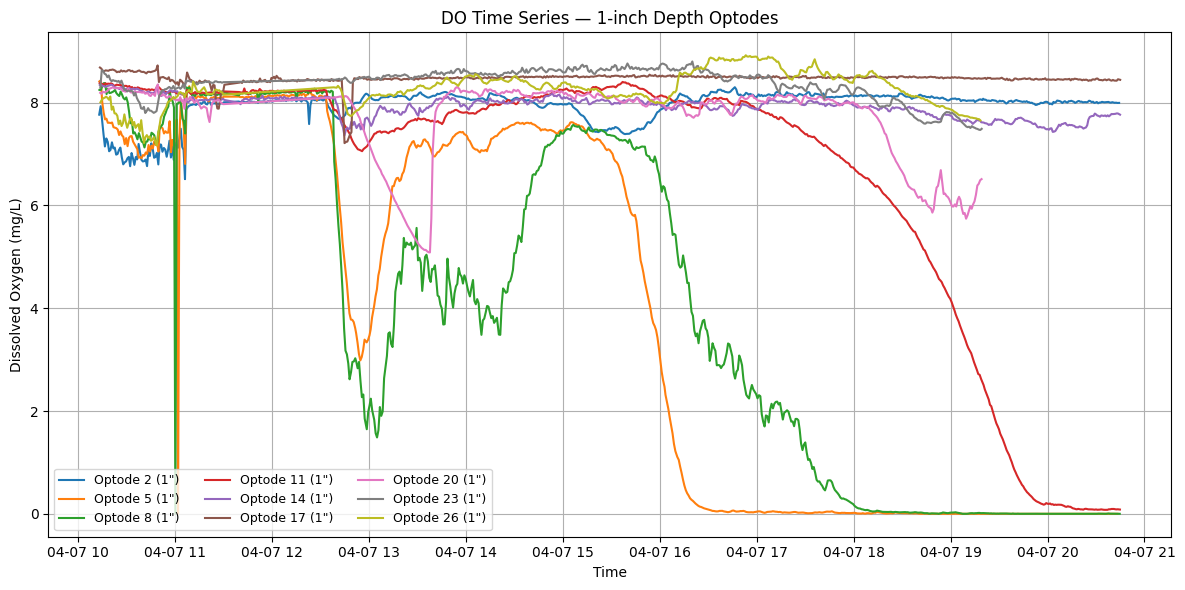

In [14]:

one_inch = all_df[all_df['depth_inch'] == 1].copy().sort_values(['optode_id','datetime'])

plt.figure(figsize=(12,6))
for oid, sub in one_inch.groupby('optode_id'):
    plt.plot(sub['datetime'], sub['DO'], label=f'Optode {oid} (1\")')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.title('DO Time Series — 1-inch Depth Optodes')
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()


## 3D DO Time–Depth Plot (All Layers)

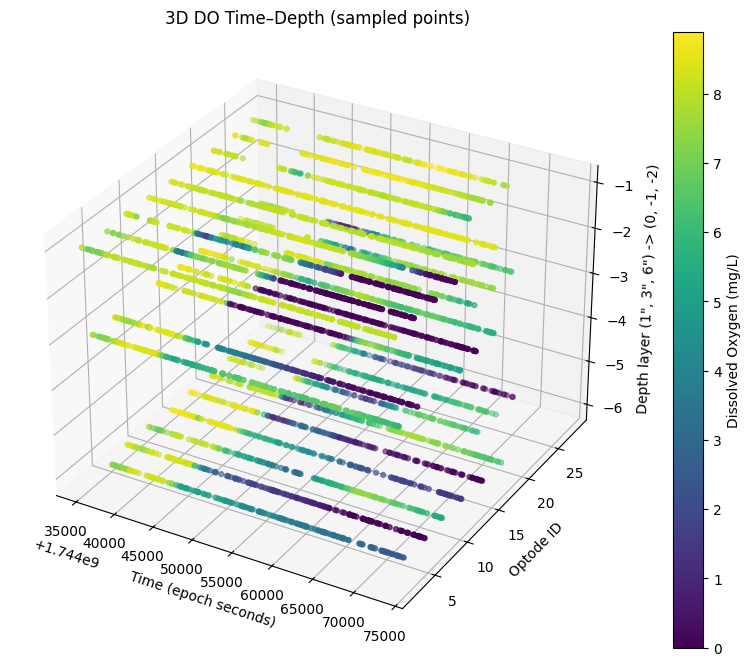

In [73]:

# Map depth to a simple z layer (higher = shallower)
depth_to_z = {1: -1, 3: -3, 6: -6}
plot_df = all_df.copy()
plot_df['z'] = plot_df['depth_inch'].map(depth_to_z)

# To keep rendering light, sample a subset; set to None for full plot
SAMPLE_N = 4000
if SAMPLE_N is not None and len(plot_df) > SAMPLE_N:
    plot_df = plot_df.sample(SAMPLE_N, random_state=42)

# Convert datetime to a numeric axis: epoch seconds
x_time = (plot_df['datetime'].astype('int64') // 10**9)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_time, plot_df['optode_id'], plot_df['z'], c=plot_df['DO'], s=12)

ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Optode ID')
ax.set_zlabel('Depth layer (1", 3", 6") -> (0, -1, -2)')
ax.set_title('3D DO Time–Depth (sampled points)')
cb = plt.colorbar(sc, ax=ax)
cb.set_label('Dissolved Oxygen (mg/L)')
plt.show()


In [64]:
x_time

15239    1744060333
1768     1744051631
4186     1744064081
6884     1744063032
8285     1744060163
            ...    
8554     1744035884
13719    1744042574
14237    1744069649
5146     1744048176
9372     1744041179
Name: datetime, Length: 4000, dtype: int64

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def make_do_gif_2d_visible(all_df, out_gif="do_over_time.gif",
                          freq="30min", window="2h", sample_n=4000, fps=8):

    depth_to_z = {1: 0, 3: -1, 6: -2}

    df = all_df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["z"] = df["depth_inch"].map(depth_to_z)
    df = df.dropna(subset=["datetime", "optode_id", "z", "DO"]).sort_values("datetime")

    # Ensure optode_id is numeric (important for offsets)
    df["optode_id"] = pd.to_numeric(df["optode_id"], errors="coerce")
    df = df.dropna(subset=["optode_id"])
    df["optode_id"] = df["optode_id"].astype(int)

    if sample_n is not None and len(df) > sample_n:
        df = df.sample(sample_n, random_state=42).sort_values("datetime")

    start = df["datetime"].min().floor(freq)
    end   = df["datetime"].max().ceil(freq)
    frame_times = pd.date_range(start, end, freq=freq)

    vmin, vmax = float(df["DO"].min()), float(df["DO"].max())

    # Set stable axis limits so points can't "fall off screen"
    x_min, x_max = df["optode_id"].min(), df["optode_id"].max()

    fig, ax = plt.subplots(figsize=(10, 6))

    # Dummy point *within* axis range so the collection is properly mappable
    sc = ax.scatter([x_min], [0], c=[vmin], s=18, cmap="viridis", vmin=vmin, vmax=vmax)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label("Dissolved Oxygen (mg/L)")

    # Clear dummy point
    sc.set_offsets(np.empty((0, 2)))
    sc.set_array(np.array([], dtype=float))

    ax.set_xlabel("Optode ID")
    ax.set_ylabel('Depth layer (1", 3", 6") → (0, -1, -2)')
    ax.set_ylim(-2.2, 0.2)
    ax.set_xlim(x_min - 1, x_max + 1)   # ✅ critical
    ax.set_yticks([-2, -1, 0])

    time_text = ax.text(0.01, 0.98, "", transform=ax.transAxes, ha="left", va="top")

    def update(i):
        t0 = frame_times[i]
        t1 = t0 + pd.Timedelta(window)

        frame = df[(df["datetime"] >= t0) & (df["datetime"] < t1)]

        if len(frame) == 0:
            sc.set_offsets(np.empty((0, 2)))
            sc.set_array(np.array([], dtype=float))
        else:
            xy = np.column_stack([
                frame["optode_id"].to_numpy(dtype=float),
                frame["z"].to_numpy(dtype=float),
            ])
            sc.set_offsets(xy)
            sc.set_array(frame["DO"].to_numpy(dtype=float))

        time_text.set_text(f"{t0:%Y-%m-%d %H:%M} → {t1:%H:%M}")
        ax.set_title("DO over time (animated)")
        return sc, time_text

    ani = FuncAnimation(fig, update, frames=len(frame_times),
                        interval=1000 // max(fps, 1), blit=False)

    ani.save(out_gif, writer=PillowWriter(fps=fps))
    plt.close(fig)
    print(f"Saved: {out_gif}")

# Example:
make_do_gif_2d_visible(all_df, out_gif="do_over_time.gif", freq="30min", window="30min", sample_n=4000, fps=2)
# after creating ani / or just after defining update:
# update(0)
plt.savefig("frame0.png", dpi=200, bbox_inches="tight")


Saved: do_over_time.gif


<Figure size 1200x600 with 0 Axes>

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation, PillowWriter

def animate_heatmaps_by_depth_only_optodes(all_df,
                                          out_gif="do_heatmap_window.gif",
                                          time_bin="30min",
                                          window="4h",
                                          step="30min",
                                          agg="mean",
                                          fps=1,
                                          depth_to_layer={1: -1, 3: -3, 6: -6},
                                          max_yticks=18):

    df = all_df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["layer"] = df["depth_inch"].map(depth_to_layer)
    df = df.dropna(subset=["datetime", "optode_id", "layer", "DO"]).sort_values("datetime")

    # Bin times for the heatmap columns
    df["tbin"] = df["datetime"].dt.floor(time_bin)

    if agg == "median":
        g = df.groupby(["layer", "optode_id", "tbin"], as_index=False)["DO"].median()
        aggfunc = "median"
    elif agg == "mean":
        g = df.groupby(["layer", "optode_id", "tbin"], as_index=False)["DO"].mean()
        aggfunc = "mean"
    else:
        raise ValueError("agg must be 'median' or 'mean'")

    layers = sorted(g["layer"].unique(), reverse=True)
    vmin, vmax = float(g["DO"].min()), float(g["DO"].max())

    # Build a pivot per layer (rows = ONLY optodes present at that depth)
    pivots = {}
    all_times = None
    for layer in layers:
        sub = g[g["layer"] == layer]
        mat = sub.pivot_table(index="optode_id", columns="tbin", values="DO", aggfunc=aggfunc)
        mat = mat.sort_index()  # optodes sorted

        all_times = mat.columns if all_times is None else all_times.union(mat.columns)
        pivots[layer] = mat

    # ✅ CRITICAL: sort the global time axis ONCE, and reindex pivots to that order
    times = pd.DatetimeIndex(all_times).sort_values()
    for layer in layers:
        pivots[layer] = pivots[layer].reindex(columns=times)

    times_num = mdates.date2num(times.to_pydatetime())

    # Frame times (window start positions)
    start = times.min()
    end = times.max()
    frame_starts = pd.date_range(start, end, freq=step)
    window_td = pd.Timedelta(window)

    # Missing values shown as white
    cmap = plt.get_cmap("viridis").copy()
    cmap.set_bad("white")

    fig, axes = plt.subplots(len(layers), 1, figsize=(14, 8), sharex=True)
    if len(layers) == 1:
        axes = [axes]

    ims = []
    for ax, layer in zip(axes, layers):
        mat = pivots[layer]
        optodes = mat.index.to_numpy()
        n_y = len(optodes)

        # Start with an empty (all-NaN) image
        init_data = np.full((n_y, 1), np.nan, dtype=float)

        # ✅ Keep datetime x-axis via extent, but use ROW-INDEX y-axis (0..n_y-1)
        extent = [times_num[0], times_num[0] + 1e-9, -0.5, n_y - 0.5]
        im = ax.imshow(init_data, aspect="auto", origin="lower",
                       vmin=vmin, vmax=vmax, extent=extent, cmap=cmap)

        # ✅ Y tick labels = only optodes present at this depth
        if n_y <= max_yticks:
            yt = np.arange(n_y)
        else:
            yt = np.linspace(0, n_y - 1, max_yticks).astype(int)

        ax.set_yticks(yt)
        ax.set_yticklabels(optodes[yt])
        ax.set_ylabel("Optode ID")
        ax.set_title(f"Depth layer {layer} (bin={time_bin}, agg={agg})")

        ims.append((im, mat, n_y))

    axes[-1].xaxis_date()
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    fig.autofmt_xdate()

    cbar = fig.colorbar(ims[0][0], ax=axes, shrink=0.9)
    cbar.set_label("Dissolved Oxygen (mg/L)")

    title = fig.suptitle("", y=0.98)

    def update(i):
        t0 = frame_starts[i]
        t1 = t0 + window_td

        # find column indices for [t0, t1) on the sorted times axis
        left = times.searchsorted(t0)
        right = times.searchsorted(t1)
        if right <= left:
            right = min(left + 1, len(times))

        x0 = times_num[left]
        x1 = times_num[right - 1] if right - 1 < len(times_num) else times_num[-1]

        for (im, mat, n_y), ax in zip(ims, axes):
            # same logic as your original code: slice visible part by iloc
            view = mat.iloc[:, left:right].to_numpy(dtype=float)

            im.set_data(view)

            # ✅ update extent: x moves with time window, y stays fixed in row-index space
            im.set_extent([x0, x1, -0.5, n_y - 0.5])

            ax.set_xlim(x0, x1)

        title.set_text(f"DO heatmaps: {t0:%Y-%m-%d %H:%M} → {t1:%Y-%m-%d %H:%M}")
        return [x[0] for x in ims] + [title]

    ani = FuncAnimation(fig, update, frames=len(frame_starts),
                        interval=1000 // max(1, fps), blit=False)

    ani.save(out_gif, writer=PillowWriter(fps=fps))
    plt.close(fig)
    print(f"Saved: {out_gif}")

# Example:
animate_heatmaps_by_depth_only_optodes(all_df, out_gif="do_heatmap_window.gif",
                                       time_bin="30min", window="4h", step="30min",
                                       fps=1, agg="mean")


/var/folders/d6/tw5j0wsn1m11p_w84_70527m0000gn/T/ipykernel_45684/670669097.py:127: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(x0, x1)


Saved: do_heatmap_window.gif


/var/folders/d6/tw5j0wsn1m11p_w84_70527m0000gn/T/ipykernel_45684/3251949.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


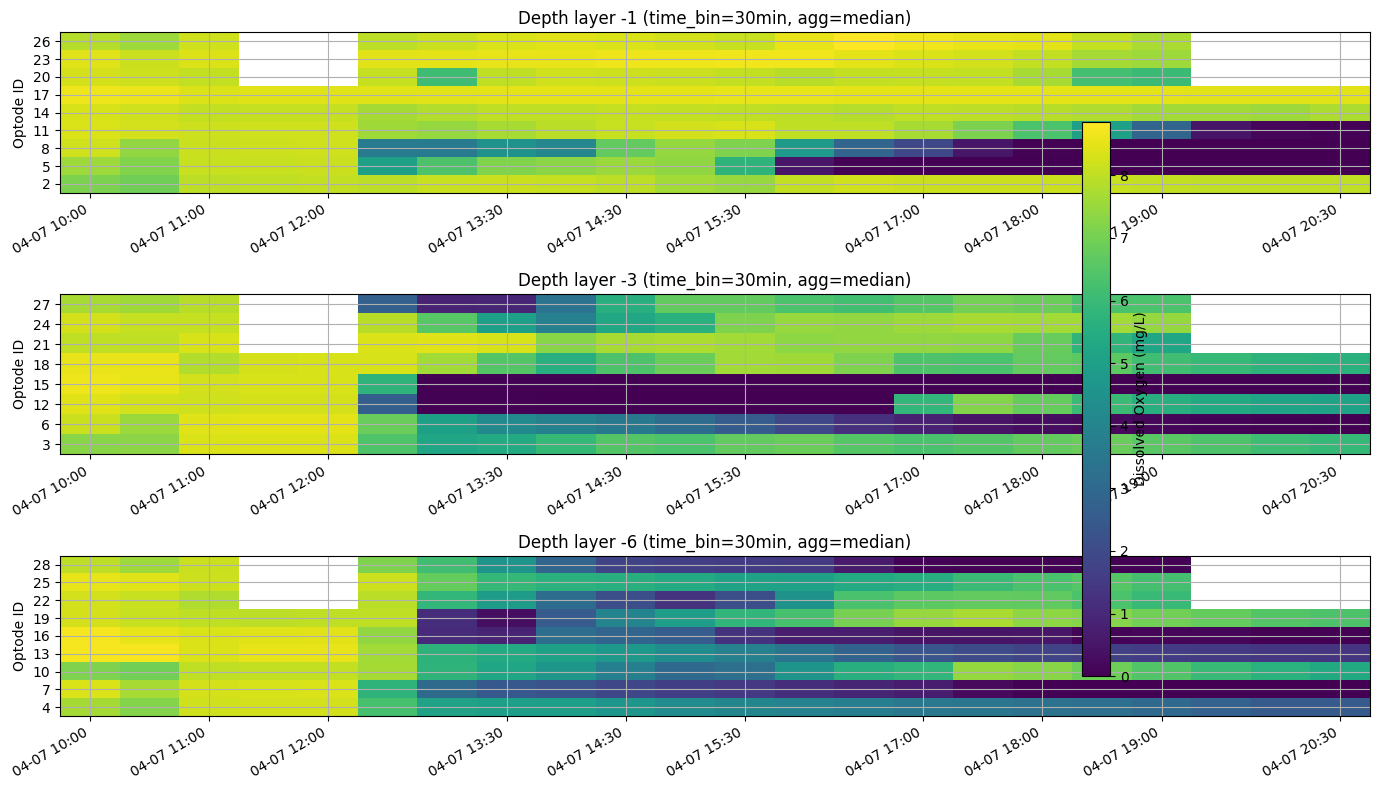

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_heatmaps_only_optodes_present(
    all_df,
    time_bin="30min",
    agg="median",
    depth_to_layer={1: -1, 3: -3, 6: -6},
    max_xticks=10,
    max_yticks=20,
):
    df = all_df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["layer"] = df["depth_inch"].map(depth_to_layer)
    df = df.dropna(subset=["datetime", "optode_id", "layer", "DO"]).sort_values("datetime")

    # bin time
    df["tbin"] = df["datetime"].dt.floor(time_bin)

    # aggregate within each (layer, optode, tbin)
    if agg == "median":
        g = df.groupby(["layer", "optode_id", "tbin"], as_index=False)["DO"].median()
    elif agg == "mean":
        g = df.groupby(["layer", "optode_id", "tbin"], as_index=False)["DO"].mean()
    else:
        raise ValueError("agg must be 'median' or 'mean'")

    layers = sorted(g["layer"].unique(), reverse=True)
    vmin, vmax = float(g["DO"].min()), float(g["DO"].max())

    # Make missing cells white
    cmap = plt.get_cmap("viridis").copy()
    cmap.set_bad("white")

    fig, axes = plt.subplots(len(layers), 1, figsize=(14, 8), sharex=False)
    if len(layers) == 1:
        axes = [axes]

    ims = []
    for ax, layer in zip(axes, layers):
        sub = g[g["layer"] == layer]
        if sub.empty:
            ax.set_title(f"Depth layer {layer} (no data)")
            continue

        # Pivot: rows=ONLY optodes present at this depth, cols=time bins
        mat = sub.pivot_table(index="optode_id", columns="tbin", values="DO", aggfunc="median")
        mat = mat.sort_index()
        mat = mat.sort_index(axis=1)

        data = mat.to_numpy(dtype=float)

        im = ax.imshow(data, aspect="auto", origin="lower",
                       vmin=vmin, vmax=vmax, cmap=cmap)
        ims.append(im)

        # --- Y axis: show only optodes that exist at this depth ---
        optodes = mat.index.to_numpy()
        n_y = len(optodes)
        if n_y <= max_yticks:
            yticks = np.arange(n_y)
        else:
            yticks = np.linspace(0, n_y - 1, max_yticks).astype(int)
        ax.set_yticks(yticks)
        ax.set_yticklabels(optodes[yticks])
        ax.set_ylabel("Optode ID")

        # --- X axis: label a subset of time bins nicely ---
        times = pd.DatetimeIndex(mat.columns)
        n_x = len(times)
        if n_x <= max_xticks:
            xticks = np.arange(n_x)
        else:
            xticks = np.linspace(0, n_x - 1, max_xticks).astype(int)
        ax.set_xticks(xticks)

        # format datetime labels
        labels = [times[i].strftime("%m-%d %H:%M") for i in xticks]
        ax.set_xticklabels(labels, rotation=30, ha="right")

        ax.set_title(f"Depth layer {layer} (time_bin={time_bin}, agg={agg})")

    # One shared colorbar
    if ims:
        cbar = fig.colorbar(ims[0], ax=axes, shrink=0.9)
        cbar.set_label("Dissolved Oxygen (mg/L)")

    plt.tight_layout()
    plt.show()

# Example:
plot_heatmaps_only_optodes_present(all_df, time_bin="30min", agg="median")


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def make_snapshot_heatmap_gif(all_df, out_gif="snapshot_heatmap.gif",
                              freq="30min", window="2h", fps=6,
                              depth_to_layer={1: 0, 3: -1, 6: -2}):

    df = all_df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["layer"] = df["depth_inch"].map(depth_to_layer)
    df = df.dropna(subset=["datetime", "optode_id", "layer", "DO"]).sort_values("datetime")

    # stable axes ordering
    optodes = np.sort(df["optode_id"].unique())
    layers = np.array(sorted(df["layer"].unique()))  # e.g. [-2, -1, 0]

    vmin, vmax = float(df["DO"].min()), float(df["DO"].max())

    start = df["datetime"].min().floor(freq)
    end = df["datetime"].max().ceil(freq)
    frame_times = pd.date_range(start, end, freq=freq)

    fig, ax = plt.subplots(figsize=(7, 8))
    # initialize with NaNs
    mat0 = np.full((len(optodes), len(layers)), np.nan, dtype=float)
    im = ax.imshow(mat0, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)

    ax.set_yticks(np.arange(len(optodes)))
    ax.set_yticklabels(optodes)
    ax.set_xticks(np.arange(len(layers)))
    ax.set_xticklabels(layers)
    ax.set_xlabel('Depth layer (1",3",6") → (0,-1,-2)')
    ax.set_ylabel("Optode ID")
    title = ax.set_title("")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("DO (mg/L)")

    # pre-index for faster filtering
    def frame_matrix(t0, t1):
        sub = df[(df["datetime"] >= t0) & (df["datetime"] < t1)]
        # median DO per (optode, layer) within the window
        piv = sub.pivot_table(index="optode_id", columns="layer", values="DO", aggfunc="median")
        # reindex to full grid
        piv = piv.reindex(index=optodes, columns=layers)
        return piv.to_numpy()

    def update(i):
        t0 = frame_times[i]
        t1 = t0 + pd.Timedelta(window)
        mat = frame_matrix(t0, t1)
        im.set_data(mat)
        title.set_text(f"{t0:%Y-%m-%d %H:%M} → {t1:%H:%M}")
        return im, title

    ani = FuncAnimation(fig, update, frames=len(frame_times), interval=1000//max(1, fps), blit=False)
    ani.save(out_gif, writer=PillowWriter(fps=fps))
    plt.close(fig)
    print(f"Saved: {out_gif}")

# Example:
make_snapshot_heatmap_gif(all_df, out_gif="snapshot_heatmap.gif", freq="30min", window="30min", fps=2)


Saved: snapshot_heatmap.gif


## Optional: Simplified 3D Arms Snapshot

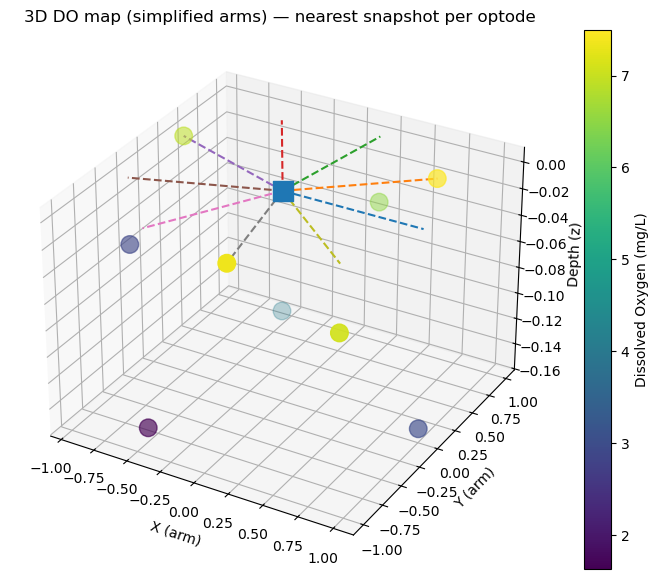

In [29]:

# Build a single-time snapshot by taking the row closest to the median time for each (optode, depth)
ref_epoch = all_df['Epoch'].median()
nearest = (all_df.assign(dist=(all_df['Epoch']-ref_epoch).abs())
           .sort_values(['optode_id','depth_inch','dist'])
           .groupby(['optode_id','depth_inch'], as_index=False)
           .first()[['optode_id','depth_inch','DO','Epoch']])

# Simplified radial arm layout (9 arms around a circle)
def arm_xy(arm_idx, R=1.0):
    theta = 2 * math.pi * (arm_idx % 9) / 9.0
    return R*math.cos(theta), R*math.sin(theta)

depth_to_z_snap = {1: 0.0, 3: -0.05, 6: -0.15}

coords = []
for _, r in nearest.iterrows():
    oid = int(r['optode_id'])
    arm = (oid - 1) % 9
    x, y = arm_xy(arm)
    z = depth_to_z_snap.get(int(r['depth_inch']), np.nan)
    if not np.isnan(z):
        coords.append((x,y,z,r['DO'],oid,int(r['depth_inch']),arm))

coords_df = pd.DataFrame(coords, columns=['x','y','z','DO','optode_id','depth_inch','arm'])
coords_df = coords_df.sort_values(['arm','depth_inch','optode_id']).drop_duplicates(['arm','depth_inch']).head(27)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(coords_df['x'], coords_df['y'], coords_df['z'], c=coords_df['DO'], s=160)
ax.scatter([0],[0],[0], s=200, marker='s')  # lander
for arm in sorted(coords_df['arm'].unique()):
    x,y = arm_xy(int(arm))
    ax.plot([0,x],[0,y],[0,0], linestyle='--')

ax.set_xlabel('X (arm)'); ax.set_ylabel('Y (arm)'); ax.set_zlabel('Depth (z)')
ax.set_title('3D DO map (simplified arms) — nearest snapshot per optode')
cb = plt.colorbar(sc, ax=ax); cb.set_label('Dissolved Oxygen (mg/L)')
plt.show()
